In [1]:
import pandas as pd, numpy as np, seaborn as sns
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, SGDRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier, BaggingClassifier, VotingRegressor, BaggingRegressor
from mlxtend.classifier import StackingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn import set_config
set_config(display="diagram")

In [4]:
df = pd.read_csv('wta.csv')
df.head(3)

,WTA,Location,Tournament,Date,Tier,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,WPts,LPts,W1,L1,W2,L2,W3,L3,Wsets,Lsets,Comment,B365W,B365L,FavRank,FavOdd,GapRank,GapOdd,TotalSets,TotalWgames,TotalLgames,TotalGames
0,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Sun T.T.,Baker L.,81.0,272.0,332.25,90.5,6.0,1.0,6.0,1.0,NaN,NaN,2.0,0.0,Completed,1.33,3.00,0.0,0.0,191.0,1.67,2.0,12.0,2.0,14.0
1,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Dulko G.,Myskina A.,59.0,16.0,401.75,1000.0,6.0,1.0,6.0,7.0,6.0,2.0,2.0,1.0,Completed,3.75,1.22,1.0,1.0,43.0,2.53,3.0,18.0,10.0,28.0
2,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Bartoli M.,Morita A.,18.0,180.0,951.00,152.0,7.0,6.0,6.0,3.0,NaN,NaN,2.0,0.0,Completed,1.16,4.50,0.0,0.0,162.0,3.34,2.0,13.0,9.0,22.0


In [9]:
df['SumOdd']=df['B365W']+df['B365L']
df['SumRank']=df['WRank']+df['LRank']

In [19]:
df['Date']=pd.to_datetime(df['Date'])
df['Month']=df['Date'].dt.month

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17802 entries, 0 to 17801
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   WTA          17802 non-null  int64         
 1   Location     17802 non-null  object        
 2   Tournament   17802 non-null  object        
 3   Date         17802 non-null  datetime64[ns]
 4   Tier         17802 non-null  object        
 5   Court        17802 non-null  object        
 6   Surface      17802 non-null  object        
 7   Round        17802 non-null  object        
 8   Best of      17802 non-null  int64         
 9   Winner       17802 non-null  object        
 10  Loser        17802 non-null  object        
 11  WRank        17802 non-null  float64       
 12  LRank        17802 non-null  float64       
 13  WPts         17802 non-null  float64       
 14  LPts         17802 non-null  float64       
 15  W1           17802 non-null  float64       
 16  L1  

In [11]:
def multiple_boxplot(df):
  plt.figure(figsize=(18,25))
  for i in range(len(df.columns)):
    plt.subplot(8, 5, i + 1)    # define figure size and subplots numbers
    plt.boxplot(x = df[df.columns[i]])
    plt.title(df.columns[i] + ' BOXPLOT')
    
    
# multiple hist
def multiple_hist(df):
  plt.figure(figsize=(18,25))
  for i in range(len(df.columns)):
      plt.subplot(8, 5, i + 1)    # define figure size and subplots numbers
      plt.hist(x = df[df.columns[i]])
      plt.title(df.columns[i] + ' HISTOGRAM')

def hist_boxplot(df):
    num_cols = len(df.columns)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, num_cols*3))
    for i, col in enumerate(df.columns):
      ax1 = axes[i, 0]
      ax2 = axes[i, 1]
      ax1.hist(df[col])
      ax1.set_title(col + ' histogram')
      
      ax2.boxplot(df[col])
      ax2.set_title(col + ' boxplot')
        
    plt.tight_layout()
    plt.show()


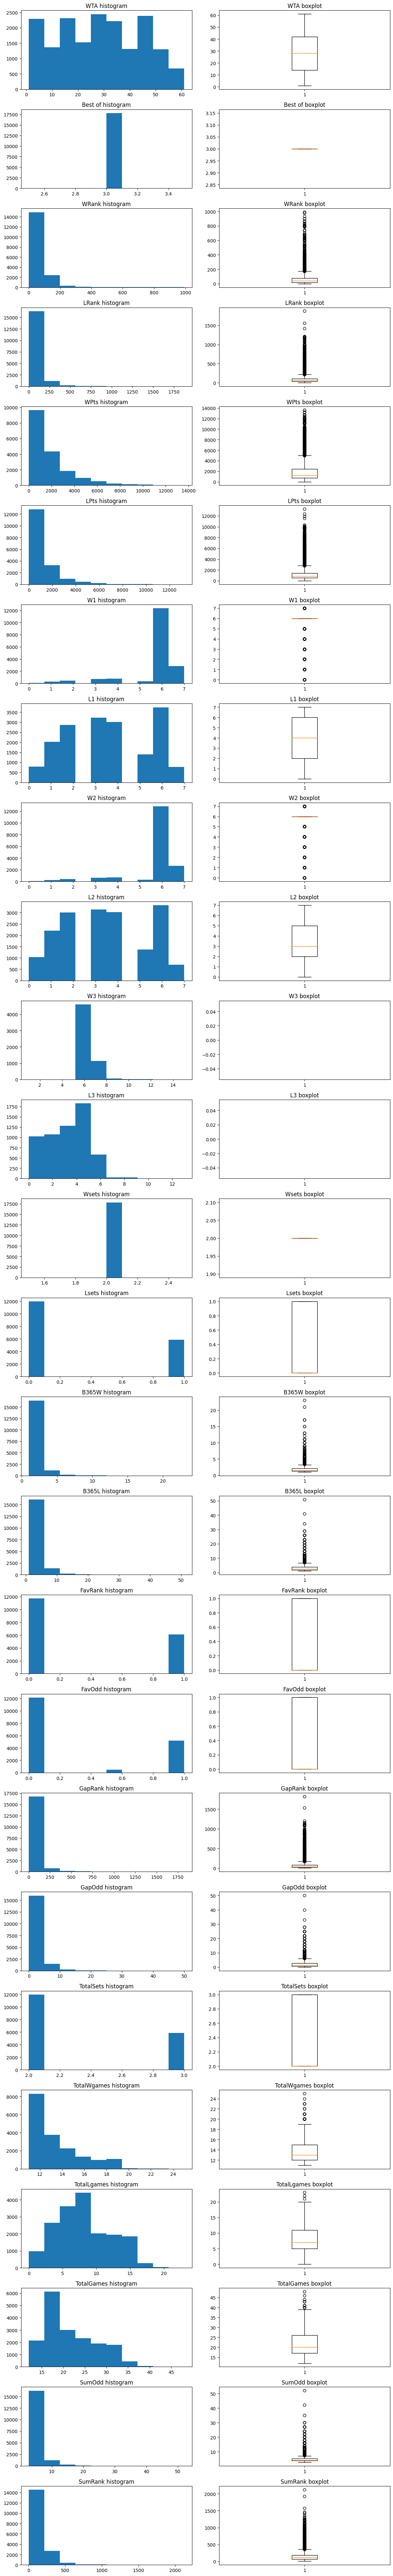

In [12]:
hist_boxplot(df.select_dtypes(include='number'))

## PRED SUR NB DE JEUX

In [22]:
df.columns

Index(['WTA', 'Location', 'Tournament', 'Date', 'Tier', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts',
       'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'Wsets', 'Lsets', 'Comment',
       'B365W', 'B365L', 'FavRank', 'FavOdd', 'GapRank', 'GapOdd', 'TotalSets',
       'TotalWgames', 'TotalLgames', 'TotalGames', 'SumOdd', 'SumRank',
       'Month'],
      dtype='object')

In [27]:
X=df.drop(columns=['Date', 'Winner', 'Loser', 'Comment', 'WTA', 'Best of', 
                   'WRank', 'WPts','LPts', 'LRank', 'B365W', 'B365L','W1', 'L1', 'W2', 'L2',  'W3', 'L3', 
                   'Wsets', 'Lsets', 'FavRank', 'FavOdd', 
                   'TotalSets', 'TotalGames', 'TotalWgames', 'TotalLgames'])

# y_rank=df['FavRank']
# y_odd=df['FavOdd']
# y_sets=df['TotalSets']
y_games=df['TotalGames']
# y_l2m=df['L2M']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y_games, test_size=0.25, random_state=42)

#### Voting

In [32]:
algo_voting=VotingRegressor(estimators=[
    ('knn', ElasticNet()), 
    ('lr', LinearRegression()), 
    ('dt', DecisionTreeRegressor())])

In [33]:
categorical_columns = ['Location', 'Tournament', 'Tier', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_voting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', algo_voting)
])

pipeline_voting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank',
                                                   'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Tier', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor',
                 VotingRegressor(estimators=[('knn', ElasticNet()),
                                             ('lr', LinearRegression()),
                                             ('dt',
                                              DecisionTreeRegressor())]))])

In [38]:
pipeline_voting.fit(X_train, y_train)

y_train_pred=pipeline_voting.predict(X_train).round()
y_test_pred=pipeline_voting.predict(X_test).round()

print(pipeline_voting.score(X_train,y_train))
print(pipeline_voting.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.5768751516966464
-2.0121877062961316e+16
rmse train : 3.7718727699836787
rmse test : 828381472.0965701


In [39]:
df_pred=pd.DataFrame()
df_pred['target']=y_test
df_pred['voting']=pipeline_voting.predict(X_test).round()

#### Boosting

In [42]:
categorical_columns = ['Location', 'Tournament', 'Tier', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_adaboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier())
])

pipeline_adaboost

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank',
                                                   'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Tier', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', AdaBoostClassifier())])

In [44]:
pipeline_adaboost.fit(X_train, y_train)

y_train_pred=pipeline_adaboost.predict(X_train).round()
y_test_pred=pipeline_adaboost.predict(X_test).round()

print(pipeline_adaboost.score(X_train,y_train))
print(pipeline_adaboost.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.08980600704067111
0.09009211413165581
rmse train : 7.208505366700588
rmse test : 7.192306606393907


In [45]:
df_pred['boosting']=pipeline_adaboost.predict(X_test).round()

#### Bagging

In [46]:
categorical_columns = ['Location', 'Tournament', 'Tier', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_bagging = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingRegressor(LinearRegression()))
])

pipeline_bagging

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank',
                                                   'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Tier', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier',
                 BaggingRegressor(base_estimator=LinearRegression()))])

In [47]:
pipeline_bagging.fit(X_train, y_train)

y_train_pred=pipeline_bagging.predict(X_train).round()
y_test_pred=pipeline_bagging.predict(X_test).round()

print(pipeline_bagging.score(X_train,y_train))
print(pipeline_bagging.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

-2.2762966301031836e+16
-8.472268705815094e+17
rmse train : 871379668.7483113
rmse test : 5375216878.108694


In [49]:
df_pred['bagging']=pipeline_bagging.predict(X_test).round()

#### Linear Reg

In [53]:
categorical_columns = ['Location', 'Tournament', 'Tier', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_linearreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

pipeline_linearreg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank',
                                                   'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Tier', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', LinearRegression())])

In [54]:
pipeline_linearreg.fit(X_train, y_train)

y_train_pred=pipeline_linearreg.predict(X_train).round()
y_test_pred=pipeline_linearreg.predict(X_test).round()

print(pipeline_linearreg.score(X_train,y_train))
print(pipeline_linearreg.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.055518349472028716
-1.810968935732957e+17
rmse train : 5.615911461059686
rmse test : 2485144416.3195176


In [55]:
df_pred['lr']=pipeline_linearreg.predict(X_test).round()

#### DecisionTree

In [56]:
categorical_columns = ['Location', 'Tournament', 'Tier', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeRegressor())
])

pipeline_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank',
                                                   'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Tier', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', DecisionTreeRegressor())])

In [57]:
pipeline_dt.fit(X_train, y_train)

y_train_pred=pipeline_dt.predict(X_train).round()
y_test_pred=pipeline_dt.predict(X_test).round()

print(pipeline_dt.score(X_train,y_train))
print(pipeline_dt.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.999683393864416
-0.9852648671574757
rmse train : 0.10313053584009427
rmse test : 8.228209855721417


In [58]:
df_pred['dt']=pipeline_dt.predict(X_test).round()

#### RandomForest

In [59]:
categorical_columns = ['Location', 'Tournament', 'Tier', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank',
                                                   'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Tier', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor', RandomForestRegressor())])

In [60]:
pipeline_rf.fit(X_train, y_train)

y_train_pred=pipeline_rf.predict(X_train).round()
y_test_pred=pipeline_rf.predict(X_test).round()

print(pipeline_rf.score(X_train,y_train))
print(pipeline_rf.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.8536699104938454
-0.058392498192707754
rmse train : 2.230987465402084
rmse test : 6.016191737265873


In [61]:
df_pred['rf']=pipeline_rf.predict(X_test).round()

#### Gradient Boosting

In [64]:
categorical_columns = ['Location', 'Tournament', 'Tier', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'SumOdd', 'SumRank', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_gradientboosting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

pipeline_gradientboosting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'SumOdd', 'SumRank',
                                                   'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Tier', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor', GradientBoostingRegressor())])

In [65]:
pipeline_gradientboosting.fit(X_train, y_train)

y_train_pred=pipeline_gradientboosting.predict(X_train).round()
y_test_pred=pipeline_gradientboosting.predict(X_test).round()

print(pipeline_gradientboosting.score(X_train,y_train))
print(pipeline_gradientboosting.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.06754798174506194
0.028833280823640117
rmse train : 5.586586329813842
rmse test : 5.762057191486388


#### Vérif pred

In [66]:
df_pred['grad']=pipeline_gradientboosting.predict(X_test).round()

In [75]:
df_pred.drop(columns=['voting'], inplace=True)

<Axes: >

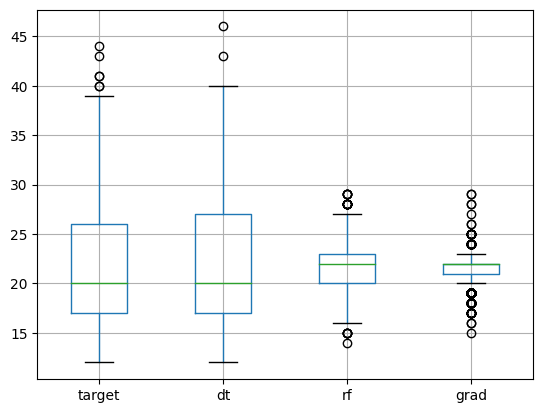

In [76]:
df_pred.boxplot()

In [77]:
df_pred.corr()

,target,dt,rf,grad
target,1.000000,0.027121,0.082321,0.165092
dt,0.027121,1.000000,0.401175,0.204153
rf,0.082321,0.401175,1.000000,0.565084
grad,0.165092,0.204153,0.565084,1.000000
